In [2]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import date, datetime
import asyncio
import httpx
import seaborn as sns



## Group Assignment
### Team Number: 10
### Team Member Names: David, Tanvi, Johan
### Team Strategy Chosen: Market Meet

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.

-------------------------------------------------------------------------------------------------------------------------------------------
#### Markdown Introduction:

Goal: Try to have the 25-stock portfolio’s returns match the average of the TSX composite + S&P 500’s return (~0.370%) as accurately as possible, over the 5-day period (Nov. 24 to Nov. 28).

- **S&P/TSX Composite Index** (`^GSPTSE`)
- **S&P 500 Index** (`^GSPC`)

| Index | YTD Return | Daily Return (÷ 252)| 5-Day Estimated Return |
|:------|:-----------:|:--------------------:|:----------------------:|
| TSX Composite | 21.74% | 0.0863% | 0.43% |
| S&P 500 | 15.55% | 0.0617% | 0.31% |
| **Average (50/50)** | — | — | **≈ 0.370%** |

Use historical data (daily returns) from `yfinance` to estimate:
  - Mean returns
  - Volatility (standard deviation)
  - Sharpe ratio (risk-adjusted return)
  - Beta and alpha risk
  - Correlation with the benchmark
  - Idiosyncratic (residual) risk

Select 10–25 stocks (we aim for 25 if possible) that:
- Have **beta ≈ 1** and high correlation with the benchmark
- Are liquid (average daily volume ≥ 5,000 shares)
- Have sector diversification (no sector >40% of total value)
- Include at least one large-cap (> 10B CAD) and one small-cap (< $2B CAD)

Weights are between (100 / (2n))% and 15% (for 25 stocks, between 2% and 15%)
- Spend approximately **$1,000,000 CAD**, net of trading fees:
- Fees = min(2.15 USD, 0.001 USD * shares) per trade, applied to all purchases
-------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
## === Temporary Test Ticker List (delete this when TA gives real Tickers.csv) ===

tickers_list = [
    "AAPL",      # US, tech
    "MSFT",      # US, tech
    "GOOGL",     # US, communications
    "AMZN",      # US, consumer cyclical
    "TSLA",      # Large-cap
    "NVDA",      # Large-cap, tech
    "JNJ",       # Large-cap, healthcare
    "WMT",       # Large-cap, consumer defensive
    "TD.TO",     # Large-cap, Canadian
    "SHOP.TO",   # Canadian tech
    "ENB.TO",    # Canadian energy
    "SU.TO",     # Canadian oil sands
    "L.TO",      # Consumer defensive Canada
    "TLRY",      # **Small-cap** Canadian (Tilray Brands)
    "AC.TO",     # Air Canada
    "BB.TO",     # BlackBerry
    "F",         # Ford
    "GM",        # General Motors
    "NKE",       # Nike
    "BABA",      # Alibaba
    "KSS" ,      # Kohl's
    "KO",        # Coca-Cola
]

In [4]:
# === 1. Original Setup & Data Download (Synchronous) ===

sp500 = "^GSPC"
tsx = "^GSPTSE"
start = "2024-01-01"
end = "2025-9-30"

min_vol = 5_000
corr_min  = 0.20
small_cap = 2_000_000_000
large_cap = 10_000_000_000
earn_low  = datetime(2025, 11, 24).date()
earn_high = datetime(2025, 11, 28).date()

# Download price + volume data (Keep synchronous, as yf.download is efficient for bulk)
tickers_all = tickers_list + [sp500, tsx]
print("Starting synchronous download of price/volume data...")
data = yf.download(tickers_all, start=start, end=end, auto_adjust=False, progress=False)
close = data["Close"]
vol = data["Volume"]
print("Price/Volume download complete.")

# Benchmark calculation (Unchanged)
bench = ((close[sp500] + close[tsx]) / 2).dropna()
bench_ret = bench.pct_change().dropna()
stocks = close[tickers_list].loc[bench_ret.index].dropna(how="all", axis=1)
rets = stocks.pct_change().dropna()

# FX rate (Keep synchronous as it's a single, fast call)
fx_raw = yf.Ticker("CADUSD=X").history(period="1d")["Close"]
usd_to_cad = fx_raw.iloc[-1] if len(fx_raw) > 0 else 0.73  # fallback rate

async def async_get_meta(ticker):
    """Asynchronously fetches metadata for a single ticker."""
    t = ticker
    try:
        ticker_obj = yf.Ticker(t)
        
        # 1. Fetch info
        # Use a try/except for info specifically to avoid crashing the whole ticker
        try:
            info = await asyncio.to_thread(lambda: ticker_obj.info)
        except:
            info = {}
            
        sector = info.get("sector")
        industry = info.get("industry")
        mc_raw = info.get("marketCap", np.nan)
        
        # 2. Market Cap Conversion
        if isinstance(mc_raw, (int, float)) and not pd.isna(mc_raw):
            mc = mc_raw if t.endswith(".TO") else mc_raw / usd_to_cad 
        else:
            mc = np.nan

        # Define booleans safely
        small = mc < small_cap if not pd.isna(mc) else False
        large = mc > large_cap if not pd.isna(mc) else False

        # 3. Fetch Earnings Date (Robust 2-Step Check)
        earn = None
        
        # Attempt #1: Calendar (Fast)
        try:
            cal = await asyncio.to_thread(lambda: ticker_obj.calendar)
            if cal and "Earnings Date" in cal:
                dates = cal["Earnings Date"]
                if dates:
                    earn = dates[0]
        except Exception:
            pass 

        # Attempt 2: Full History (Backup)
        if earn is None:
            try:
                e_df = await asyncio.to_thread(lambda: ticker_obj.get_earnings_dates(limit=12))
                if e_df is not None and not e_df.empty:
                    future = [d.date() for d in e_df.index.to_pydatetime() if d.date() >= datetime.now().date()]
                    if future:
                        earn = min(future)
            except Exception:
                pass 

        return {
            "Ticker": t,
            "Sector": sector,
            "Industry": industry,
            "MarketCap": mc,
            "Small-cap": small,  
            "Large-cap": large,  
            "Earnings Date": earn
        }

    except Exception as e:
        # Fallback for total failure
        return {
            "Ticker": t,
            "Sector": np.nan, "Industry": np.nan, "MarketCap": np.nan,
            "Small-cap": False, 
            "Large-cap": False, 
            "Earnings Date": None
        }
    
async def fetch_all_metadata(tickers):
    print("Starting asynchronous metadata fetching with delay...")
    tasks = []
    for i, t in enumerate(tickers):
        # Create the metadata fetching task
        task = async_get_meta(t)
        tasks.append(task)

        # Pause execution for a short time every few requests
        if i > 0 and i % 5 == 0: # Example: pause every 5 tickers
            await asyncio.sleep(0.25) 

    # Now, gather all tasks that have been created
    results = await asyncio.gather(*tasks)
    print("Metadata retrieval complete.")
    return results

metadata_results = await fetch_all_metadata(stocks.columns)

# Convert results to DataFrame
meta = pd.DataFrame(metadata_results).set_index("Ticker")
meta = meta.loc[stocks.columns] # Re-align index order
meta["Small-cap"] = meta["Small-cap"].astype(bool)
meta["Large-cap"] = meta["Large-cap"].astype(bool)

# Helper functions
def avg_volume(series): 
    """Average daily volume after removing months with <18 trading days."""
    s = series.dropna()
    if s.empty: return np.nan
    month = s.index.to_period("M")
    valid = month.value_counts()[lambda x: x >= 18].index
    return s[month.isin(valid)].mean()

def weekly_vol(r):
    """Weekly volatility computed from daily returns."""
    w = (1 + r).resample("W-FRI").prod() - 1
    w = w.dropna()
    return w.std() if not w.empty else np.nan

Starting synchronous download of price/volume data...
Price/Volume download complete.
Starting asynchronous metadata fetching with delay...
Metadata retrieval complete.


In [5]:
# === 2. Compute Stock/Benchmark Metrics ===

metrics = pd.DataFrame(index=stocks.columns,
                       columns=["AvgVol", "StdDev (%)", "Covariance", "Beta", "Correlation", "WeeklyVol %","IdioVol %"],
                       dtype=float)

for t in stocks.columns:
    r = rets[t].dropna()
    b = bench_ret.reindex(r.index).dropna()

    # Align
    idx = r.index.intersection(b.index)
    r = r.loc[idx]
    b = b.loc[idx]

    # Calculations
    av = avg_volume(vol[t].loc[start:end])
    sd = r.std() * 100
    cv = r.cov(b) * (100**2)
    beta = cv / (b.var() * (100**2)) if b.var() > 0 else np.nan
    corr = r.corr(b)
    wv = weekly_vol(r) * 100

# Idiosyncratic Volatility
# Formula: Std Dev of (Actual Return - Expected Return)
# Expected Return = Alpha + (Beta * Benchmark Return)
    if not np.isnan(beta):
        # Calculate Alpha (Intercept)
        alpha = r.mean() - beta * b.mean()
        
        # Calculate Residuals (The noise not explained by the benchmark)
        residuals = r - (alpha + beta * b)
        
        # Calculate Idiosyncratic Volatility (Std Dev of residuals)
        iv = residuals.std() * 100
    else:
        iv = np.nan

    metrics.loc[t] = [av, sd, cv, beta, corr, wv, iv]

# --- Apply assignment filters & requirements ---

keep_vol = metrics["AvgVol"] >= min_vol
keep_corr = metrics["Correlation"] >= corr_min

keep_earn = pd.Series(True, index=metrics.index)
for t in metrics.index:
    e = meta.loc[t, "Earnings Date"]
    # Check if small-cap AND earnings date is within the forbidden window
    if meta.loc[t, "Small-cap"] and isinstance(e, date):
        if earn_low <= e <= earn_high:
            keep_earn[t] = False

mask = keep_vol & keep_corr & keep_earn

filtered = metrics[mask].join(meta, how="left")
filtered_tickers = list(filtered.index)

print("\n--- Results ---")
print("Original:", len(tickers_list))
print("After Filters:", len(filtered_tickers))
display(filtered.head(25))

# --- Benchmark reference data ---

bench_std = bench_ret.std() * 100
bench_week = weekly_vol(bench_ret) * 100

print("Benchmark Std Dev:", bench_std)
print("Benchmark Weekly Volatility:", bench_week)


--- Results ---
Original: 22
After Filters: 20


,AvgVol,StdDev (%),Covariance,Beta,Correlation,WeeklyVol %,IdioVol %,Sector,Industry,MarketCap,Small-cap,Large-cap,Earnings Date
Ticker,,,,,,,,,,,,,
AAPL,5.720343e+07,1.874138,0.852491,1.318346,0.565663,3.987233,1.545482,Technology,Consumer Electronics,5.677369e+12,False,True,2026-01-29
MSFT,2.121733e+07,1.434521,0.656506,1.015262,0.569117,3.013574,1.179544,Technology,Software - Infrastructure,4.945090e+12,False,True,2026-01-28
GOOGL,3.131721e+07,1.936572,0.721867,1.116340,0.463546,4.119306,1.715944,Communication Services,Internet Content & Information,5.114427e+12,False,True,2025-10-29
AMZN,4.233414e+07,1.989823,0.974934,1.507698,0.609299,3.882665,1.577811,Consumer Cyclical,Internet Retail,3.324429e+12,False,True,2025-10-30
TSLA,9.829029e+07,4.196645,1.616347,2.499619,0.478963,8.400378,3.683963,Consumer Cyclical,Auto Manufacturers,1.832835e+12,False,True,2026-01-28
NVDA,3.162049e+08,3.336022,1.422640,2.200058,0.530317,6.963314,2.828277,Technology,Semiconductors,6.147210e+12,False,True,2025-11-19
WMT,1.774329e+07,1.366257,0.451391,0.698060,0.410857,2.982972,1.245616,Consumer Defensive,Discount Stores,1.184362e+12,False,True,2025-11-20
TD.TO,7.340803e+06,1.118661,0.390425,0.603777,0.434019,2.483708,1.007806,Financial Services,Banks - Diversified,1.991012e+11,False,True,2025-12-04
SHOP.TO,2.354477e+06,3.621671,1.734553,2.682421,0.595591,8.159583,2.909243,Technology,Software - Application,2.711478e+11,False,True,2025-11-04


Benchmark Std Dev: 0.8034836577141854
Benchmark Weekly Volatility: 1.48885560758792


In [6]:
## === 3. Historical Stock Returns vs TSX/S&P 500 Benchmark ===

periods = [5, 21, 63, 252]

# Prices aligned with benchmark dates
px = stocks[filtered_tickers].loc[stocks.index.intersection(bench.index)].dropna(how="all", axis=1)

def trailing_ret(series, d):
    s = series.dropna()
    if len(s) <= 1: return np.nan
    if len(s) <= d: return (s.iloc[-1] / s.iloc[0] - 1) * 100
    return (s.iloc[-1] / s.iloc[-(d+1)] - 1) * 100

def calc_avg_weekly(series):
    """Calculates the mean weekly return (%) over the available period."""
    # Resample to Weekly (Friday Close)
    w_prices = series.dropna().resample("W-FRI").last()
    # Calculate % Change
    w_rets = w_prices.pct_change().dropna()
    # Return Mean * 100
    return w_rets.mean() * 100

# Stock returns table
# UPDATED: Added "Avg Weekly (%)" to the column list
stock_returns = pd.DataFrame(index=px.columns,
                             columns=[f"{d}d" for d in periods] + ["Avg Weekly (%)"])

for t in px.columns:
    for d in periods:
        stock_returns.loc[t, f"{d}d"] = trailing_ret(px[t], d)
    
    # Calculate and store Avg Weekly Return for the stock
    stock_returns.loc[t, "Avg Weekly (%)"] = calc_avg_weekly(px[t])

# Benchmark returns table
bench_returns = pd.DataFrame(index=[f"{d}d" for d in periods],
                             columns=["TSX/S&P Benchmark (%)"])

for d in periods:
    bench_returns.loc[f"{d}d"] = trailing_ret(bench, d)

# UPDATED: Add the Benchmark's Avg Weekly Return as a new row
bench_returns.loc["Avg Weekly (%)"] = calc_avg_weekly(bench)

# Formatting
stock_returns = stock_returns.astype(float).round(2)
bench_returns = bench_returns.astype(float).round(2)

display(stock_returns)
display(bench_returns)

,5d,21d,63d,252d,Avg Weekly (%)
Ticker,,,,,
AAPL,-0.64,9.40,26.58,15.29,0.45
MSFT,0.03,0.97,3.45,19.45,0.41
GOOGL,-3.36,15.31,40.63,52.71,0.73
AMZN,-2.40,-4.07,2.33,19.17,0.54
TSLA,2.07,28.10,36.05,95.07,1.03
NVDA,-0.96,0.93,17.31,60.40,1.69
WMT,0.25,7.25,7.35,30.43,0.79
TD.TO,1.41,10.81,11.71,30.32,0.31
SHOP.TO,-4.52,6.51,34.53,102.40,1.13


,TSX/S&P Benchmark (%)
5d,-0.05
21d,4.86
63d,11.37
252d,25.41
Avg Weekly (%),0.40


In [7]:
# === 4. Scoring & Normalization ===

# 1. Merge Dataframes
# We need 'Avg Weekly (%)' from stock_returns combined with Beta/Idio/Cap from filtered
df_score = filtered.join(stock_returns["Avg Weekly (%)"], how="inner")

# 2. Get Benchmark Target Return
target_return = bench_returns.loc["Avg Weekly (%)", "TSX/S&P Benchmark (%)"]
print(f"Target Benchmark Weekly Return: {target_return}%")

# score calc 

# A. Beta Score (40%)
# Logic: Minimize the distance (gap) between Stock Beta and 1.0
df_score["Beta_Gap"] = (df_score["Beta"] - 1.0).abs()
# Rank: Ascending=False means Smallest Gap gets Highest Score
df_score["Rank_Beta"] = df_score["Beta_Gap"].rank(ascending=False)

# B. Return Score (20%)
# Logic: Minimize the distance (gap) between Stock Return and Benchmark Return
df_score["Return_Gap"] = (df_score["Avg Weekly (%)"] - target_return).abs()
# Rank: Ascending=False means Smallest Gap gets Highest Score
df_score["Rank_Return"] = df_score["Return_Gap"].rank(ascending=False)

# C. Idiosyncratic Volatility Score (20%)
# Logic: Lower is Better (Minimize Noise)
# Rank: Ascending=False means Lowest Volatility gets Highest Score
df_score["Rank_Idio"] = df_score["IdioVol %"].rank(ascending=False)

# D. Market Cap Score (20%)
# Logic: Higher is Better (Liquidity & Index Drivers)
# Rank: Ascending=True means Highest Cap gets Highest Score
df_score["Rank_Cap"] = df_score["MarketCap"].rank(ascending=True)

# final weighted score
# Normalize ranks to a 0-100 scale relative to the number of stocks
n_stocks = len(df_score)

# Weights: Beta=4, Others=2 (Total = 10 parts)
# Formula: (4*Beta + 2*Cap + 2*Return + 2*Idio) / 10
df_score["Final_Score"] = (
    (0.40 * df_score["Rank_Beta"]) +
    (0.20 * df_score["Rank_Return"]) +
    (0.20 * df_score["Rank_Idio"]) +
    (0.20 * df_score["Rank_Cap"])
)

# Sort by Final Score
df_final = df_score.sort_values("Final_Score", ascending=False)

# --- SELECTION & CONSTRAINTS ---

# 1. Initial Attempt: Pick Top 25
top_25 = df_final.head(25).copy() 

# 2. Check for Small Cap Constraint
# FIX: Changed 'top_selection' to 'top_25'
has_small = top_25["Small-cap"].any()

if not has_small:
    #No Small Cap in Top 25. So swapping lowest ranked large cap with best available small cap
    
    # Identify candidates: Stocks NOT in the top 25 that ARE Small-caps
    # We use iloc[25:] to look at stocks ranked 26th and below
    remaining_stocks = df_final.iloc[25:]
    
    small_cap_candidates = remaining_stocks[remaining_stocks["Small-cap"] == True]
    
    if not small_cap_candidates.empty:
        # A. Find the best available Small Cap (First one, since df_final is sorted)
        best_small_cap = small_cap_candidates.iloc[[0]]
        
        # B. Drop the lowest ranked stock from our Top 25 (The last one)
        top_25 = top_25.iloc[:-1]
        
        # C. Add the Small Cap
        top_25 = pd.concat([top_25, best_small_cap])
        
        print(f"Replaced rank 25 with Small Cap '{best_small_cap.index[0]}'.")
        
    

# 3. Final Formatting
cols_to_show = ["Beta", "Beta_Gap", "Avg Weekly (%)", "Return_Gap", "IdioVol %", "MarketCap", "Final_Score", "Small-cap"]

print("\n--- Final Portfolio Selection ---")
display(top_25[cols_to_show])

# Final Logic Check
print(f"\nFinal Size: {len(top_25)}")
print(f"Has Large Cap: {top_25['Large-cap'].any()}")
print(f"Has Small Cap: {top_25['Small-cap'].any()}")

Target Benchmark Weekly Return: 0.4%

--- Final Portfolio Selection ---


,Beta,Beta_Gap,Avg Weekly (%),Return_Gap,IdioVol %,MarketCap,Final_Score,Small-cap
Ticker,,,,,,,,
MSFT,1.015262,0.015262,0.41,0.01,1.179544,4.945090e+12,18.6,False
SU.TO,1.034992,0.034992,0.35,0.05,1.449102,7.574299e+10,15.4,False
GOOGL,1.116340,0.116340,0.73,0.33,1.715944,5.114427e+12,14.6,False
AAPL,1.318346,0.318346,0.45,0.05,1.545482,5.677369e+12,14.6,False
ENB.TO,0.434509,0.565491,0.40,0.00,0.887154,1.474542e+11,13.2,False
TD.TO,0.603777,0.396223,0.31,0.09,1.007806,1.991012e+11,13.2,False
GM,1.163345,0.163345,0.66,0.26,1.918513,9.435416e+10,12.6,False
WMT,0.698060,0.301940,0.79,0.39,1.245616,1.184362e+12,12.4,False
AMZN,1.507698,0.507698,0.54,0.14,1.577811,3.324429e+12,12.4,False



Final Size: 20
Has Large Cap: True
Has Small Cap: True


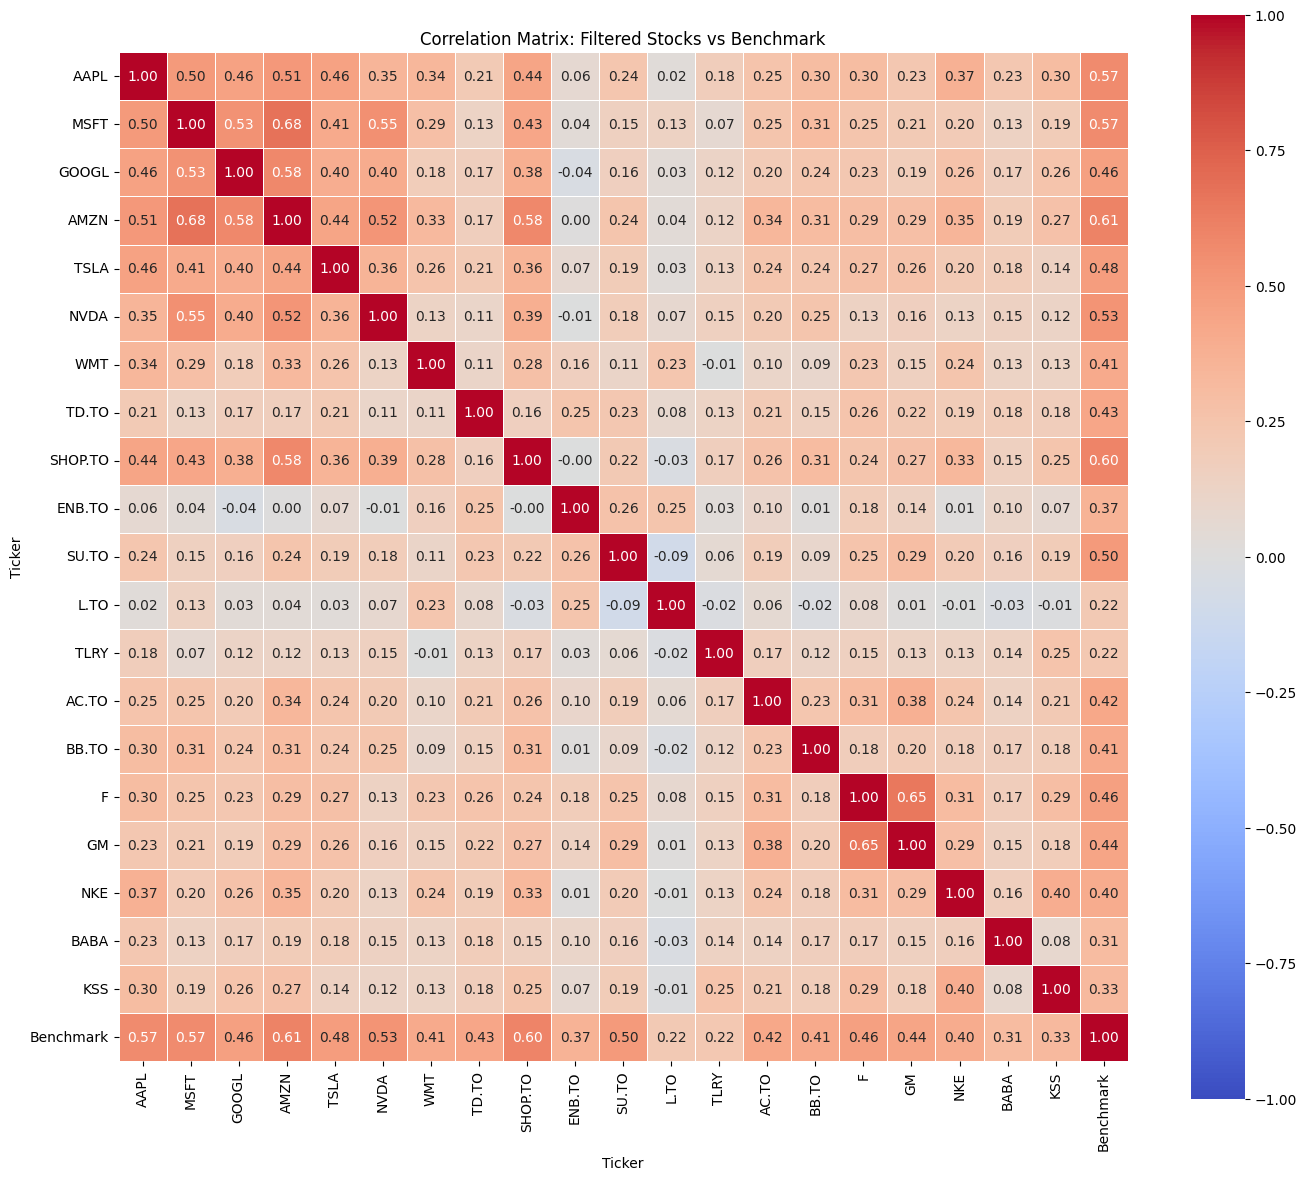

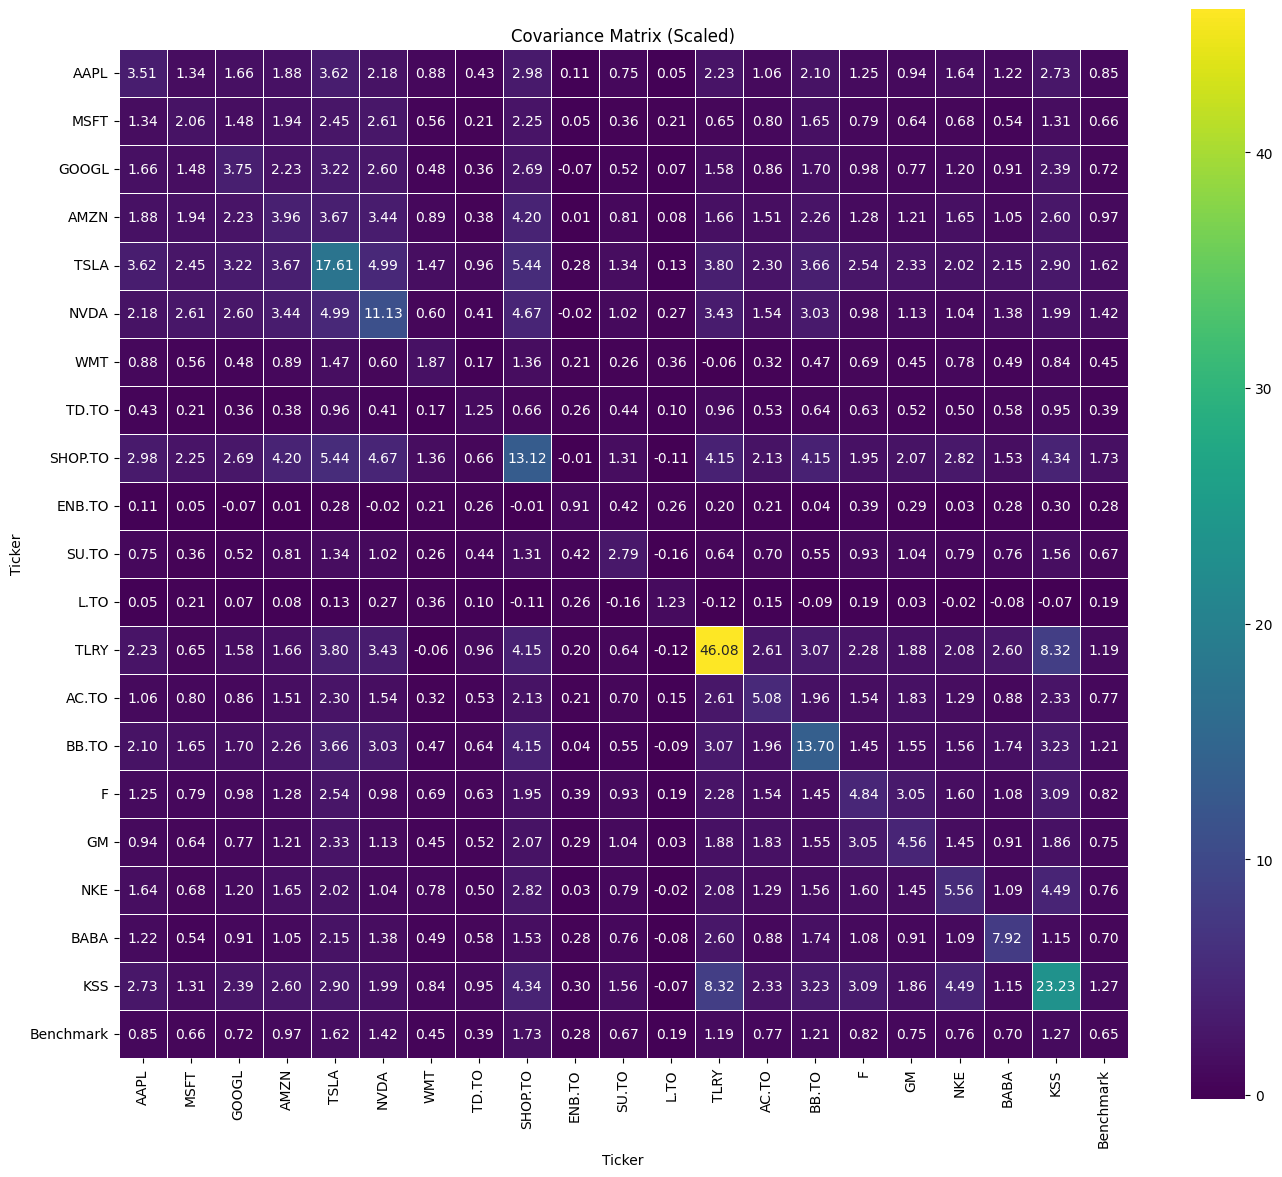

In [8]:
# === 5. Visualizing the Data ===

import seaborn as sns

# Correlation & Covariance Heatmaps

# 1. Prepare  data
heatmap_data = rets[filtered_tickers].copy()
heatmap_data["Benchmark"] = bench_ret # Add benchmark for comparison

# 2. Compute Matrices
corr_matrix = heatmap_data.corr()
cov_matrix = heatmap_data.cov() * (100**2) # Scale up covariance for readability (like in metrics)

# 3. Plot Correlation Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Correlation Matrix: Filtered Stocks vs Benchmark")
plt.tight_layout()
plt.show()

# 4. Plot Covariance Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, linewidths=0.5)
plt.title("Covariance Matrix (Scaled)")
plt.tight_layout()
plt.show()


For the diagonal reprsenting the covariance between the same stocks, we get just variance of the stock

In [ ]:
# === 5. Portfolio Optimization ===

def optimize_weights_for_top25(rets, stock_returns, bench_returns, top25, meta, df_score, lam=0.01):

    #get list of the selected tickers
    tickers = list(top25.index)

    #get final score values for these tickers
    score_vec = df_score.loc[tickers, "Final_Score"].astype(float)

    #normalize scores so they sum to one
    score_norm = score_vec / score_vec.sum()

    #get each stock's weekly return
    weekly_stock_ret = stock_returns.loc[tickers, "Avg Weekly (%)"].astype(float) / 100

    #get benchmark weekly return
    weekly_bench_ret = float(bench_returns.loc["Avg Weekly (%)", "TSX/S&P Benchmark (%)"]) / 100

    #objective combines strong return matching and score alignment
    def objective(weights):
        #compute portfolio weekly return
        port_ret = np.dot(weights, weekly_stock_ret)

        #we square the difference between portfolio return and benchmark return
        #then multiply by 1,000,000 so that even tiny differences become extremely important to the optimizer
        #which forecs the portfolio return to match the benchmark as close as it can
        track_err = 1_000_000 * (port_ret - weekly_bench_ret)**2

        #score alignment encourages high scoring stocks to have higher weights
        score_err = np.sum((weights - score_norm)**2)

        #final objective
        return track_err + lam * score_err

    #weights must sum to one
    def sum_to_one(weights):
        return np.sum(weights) - 1

    #sector must not exceed forty percent
    def sector_check(weights):
        sector_totals = {}
        for i, t in enumerate(tickers):
            sec = meta.loc[t, "Sector"]
            if sec not in sector_totals:
                sector_totals[sec] = 0
            sector_totals[sec] += weights[i]
        return min(0.40 - w for w in sector_totals.values())

    #ensure at least one large cap
    def large_cap_check(weights):
        total = 0
        for i, t in enumerate(tickers):
            if meta.loc[t, "MarketCap"] > 10_000_000_000:
                total += weights[i]
        return total - (1 / len(tickers))

    #ensure at least one small cap
    def small_cap_check(weights):
        total = 0
        for i, t in enumerate(tickers):
            if meta.loc[t, "MarketCap"] < 2_000_000_000:
                total += weights[i]
        return total - (1 / len(tickers))

    #constraint list
    constraints = [
        {'type': 'eq',  'fun': sum_to_one},
        {'type': 'ineq','fun': sector_check},
        {'type': 'ineq','fun': large_cap_check},
        {'type': 'ineq','fun': small_cap_check},
    ]

    #assignment weight bounds
    min_weight = 1 / (2 * len(tickers))
    bounds = [(min_weight, 0.15)] * len(tickers)

    #start near score distribution
    starting_guess = np.array(score_norm)

    #run optimizer
    result = minimize(
        fun=objective,
        x0=starting_guess,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 5000, "disp": True}
    )

    #normalize weights
    weights = result.x
    weights = weights / np.sum(weights)

    #compute final return and difference
    final_port_ret = np.dot(weights, weekly_stock_ret)
    difference = abs(final_port_ret - weekly_bench_ret)

    #print results
    print("\nOptimization:")
    print("Benchmark Weekly Return:", weekly_bench_ret)
    print("Portfolio Weekly Return:", final_port_ret)
    print("Absolute Difference:", difference)
    print("Sum of Weights:", np.sum(weights))

    return pd.Series(weights, index=tickers)

opt_weights = optimize_weights_for_top25(
    rets = rets,
    stock_returns = stock_returns,
    bench_returns = bench_returns,
    top25 = top_25,
    meta = meta,
    df_score = df_score
)

display(opt_weights)

In [52]:
# === 7. Output the Portfolio's Data Frame & Export the .csv file ===



------------------------------------------------------------------------------------
Output must include:
- Portfolio_Final DataFrame: Index 1…n; columns: Ticker, Price, Currency, Shares, Value, Weight.
- Stocks_Final CSV: Only Ticker and Shares, named Stocks_Group_XX.csv.
- Display total portfolio value = $1,000,000 CAD minus fees, with stock weights summing to 100%.
- Explain your strategy with markdown, charts, and statistics, using concepts from the course.
- Code should be clean, well-commented, and avoid hardcoding.

Personal Note: Produce one final data frame that contains all of the filtered stocks with the columns above. Then export these stocks into a .csv file that only contains their tickers + # of shares.

#### Markdown Conclusion:
According to our chosen strategy (Market Meet), our goal was to generate a portfolio return as close as possible to the benchmark average (above or below) of the S&P/TSX Composite and the S&P 500 indices.

Here is a step-by-step overview of the main code sections, as well as an explanation of our understanding:

#### 1. Parse the Tickers.csv file and extract ticker data (market capitalization, sector, industry, daily volume) from yfinance.

In this section, the code reads the TA-provided Tickers.csv file and downloads one full year of daily price and volume data (between 2024-10-01 and 2025-09-30) for every ticker, plus the S&P 500 and TSX Composite benchmarks. The script extracts each company’s sector, industry, market capitalization, and upcoming earnings date using yfinance.Ticker().info. Market caps are normalized into CAD, ensuring U.S. tickers (such as AAPL at approximately USD 3.0T) are directly comparable to Canadian ones under the assignment thresholds (< CAD 2B small-cap, > CAD 10B large-cap). The average daily volume is calculated after removing any month with fewer than 18 trading days. This generates a complete and consistent dataset that later filtering and calculations rely on.

#### 2. Calculate metrics: Beta, Relative Standard Deviation (StdDev), Weekly Volatility (Weekly Vol), Covariance

In this stage, the code computes all statistical metrics using the return series aligned to the benchmark. Daily standard deviation is converted into percentage units (e.g., many large-caps fall in the 1–3% daily volatility range, while higher-risk names may exceed 4–5%). Covariance values are scaled into percent-squared units, often ranging from 0.01 to 0.15 depending on the stock’s co-movement with the benchmark. Beta is calculated as Cov/Var, typically producing values between 0.6–1.8 depending on the stock’s sensitivity. Weekly volatility is computed by compounding daily returns into weekly returns, then taking the standard deviation of that series; stable names often show 3–6% weekly volatility, while higher-risk ones can exceed 10–12%. Correlation values usually cluster between 0.20 and 0.90.

#### 3. Calculate historical stock & benchmark returns (5 days, 21d, 63d, 252d)

This section computes trailing percentage returns for each stock and the benchmark across 5-day, 21-day, 63-day, and 252-day windows. When the available price history is shorter than the required window, the script uses the earliest available price to compute a valid return. These returns typically range widely: 5-day values often fall between −10% and +12% for volatile tickers, while 63-day values often lie between −20% and +25%. The benchmark’s returns are usually narrower, such as −3% to +4% over 21 days and −8% to +12% over 252 days. The resulting DataFrames present all values in percentage format for clear interpretation during subsequent scoring and selection steps.

#### 4. Assign a weighted point value score per stock, for every category based on importance [Beta (40%), Market Cap (20%), Returns (20%), & Volatility (20%)]

In this part of the code, each stock receives a numerical score derived from its beta, market cap, volatility, and return on investment (ROI), each normalized and then weighted by the importance levels selected by the group. The 40% beta component favours values near 1.00, the 20% market cap component increases the score of larger firms (which may range from CAD 50B to CAD 3T), and the 20% volatility component lowers the score of stocks with higher daily or weekly variability (such as weekly volatility exceeding 8–10%). The 20% returns column focuses on how accurate a stock's weekly returns are relative to the 50/50 benchmark. The sum of these points is tallied into a single total score used to rank each filtered stock.

#### 5. Optimize the large-cap portfolio (# of valid filtered stocks - 1), replace the lowest scoring large-cap stock with the highest scoring small-cap stock. Note: Check if there is a small-cap in the filtered list of valid stocks.

After all stocks are scored, the code selects the top-ranked large-cap stocks (market cap > CAD 10B) and checks whether any small-cap stocks (< CAD 2B) remain in the filtered set. If at least one small-cap is present, the script replaces the lowest-ranked large-cap with the highest-ranked small-cap to satisfy the assignment requirement. The optimizer then computes position weights subject to the constraints: no position above 15%, a minimum weight of 100/(2n)%, sector exposure below 40%, and total allocated amount near $1,000,000 CAD after applying the fee rule (2.15 USD or 0.001/share). Share quantities are then calculated from these weights and the last available price data.

#### 6. Visualize the data (Correlation heatmaps, Time-series graphs, Pie charts)

***In this section, the code produces visual summaries that make the structure of the filtered stocks and the final portfolio easy to understand. A correlation heatmap shows how closely each stock’s returns move together and how strongly they relate to the benchmark. A covariance heatmap presents the differences in joint variability between stock pairs. Time-series plots display each stock’s beta and volatility values so they can be compared directly across the filtered universe. Sector pie charts show how the portfolio’s exposure is distributed across industries, and a separate pie chart shows the weight assigned to each stock.

#### 7. Output the final stock portfolio data frame and export the Tickers + # of shares to a .csv file

This stage creates the Portfolio_Final DataFrame, containing each selected stock’s ticker, last traded price, currency, number of shares, total CAD value, and final optimized portfolio weight. The script verifies that the portfolio value stays near the $1,000,000 CAD budget after fees and that the weights sum exactly to 100%. It then exports the required Stocks_Final CSV file containing only the ticker and number of shares for submission. These outputs summarize the final optimized portfolio using only the results produced by the earlier filtering, scoring, and allocation steps.